In [1]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
from glob import glob

In [2]:
def imshow(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
class VAE(nn.Module):
    def __init__(self, nc, ngf, ndf, latent_variable_size):
        super(VAE, self).__init__()

        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        self.latent_variable_size = latent_variable_size

        # encoder
        self.e1 = nn.Conv2d(nc, ndf, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(ndf)

        self.e2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(ndf*2)

        self.e3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(ndf*4)

        self.e4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(ndf*8)

        self.e5 = nn.Conv2d(ndf*8, ndf*8, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(ndf*8)

        self.fc1 = nn.Linear(ndf*8*4*4, latent_variable_size)
        self.fc2 = nn.Linear(ndf*8*4*4, latent_variable_size)

        # decoder
        self.d1 = nn.Linear(latent_variable_size, ngf*8*2*4*4)

        self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd1 = nn.ReplicationPad2d(1)
        self.d2 = nn.Conv2d(ngf*8*2, ngf*8, 3, 1)
        self.bn6 = nn.BatchNorm2d(ngf*8, 1.e-3)

        self.up2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd2 = nn.ReplicationPad2d(1)
        self.d3 = nn.Conv2d(ngf*8, ngf*4, 3, 1)
        self.bn7 = nn.BatchNorm2d(ngf*4, 1.e-3)

        self.up3 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd3 = nn.ReplicationPad2d(1)
        self.d4 = nn.Conv2d(ngf*4, ngf*2, 3, 1)
        self.bn8 = nn.BatchNorm2d(ngf*2, 1.e-3)

        self.up4 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd4 = nn.ReplicationPad2d(1)
        self.d5 = nn.Conv2d(ngf*2, ngf, 3, 1)
        self.bn9 = nn.BatchNorm2d(ngf, 1.e-3)

        self.up5 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd5 = nn.ReplicationPad2d(1)
        self.d6 = nn.Conv2d(ngf, nc, 3, 1)

        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.leakyrelu(self.bn1(self.e1(x)))
        h2 = self.leakyrelu(self.bn2(self.e2(h1)))
        h3 = self.leakyrelu(self.bn3(self.e3(h2)))
        h4 = self.leakyrelu(self.bn4(self.e4(h3)))
        h5 = self.leakyrelu(self.bn5(self.e5(h4)))
        h5 = h5.view(-1, self.ndf*8*4*4)

        return self.fc1(h5), self.fc2(h5)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        # eps = Variable(eps)
        eps = eps.to(device)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h1 = self.relu(self.d1(z))
        h1 = h1.view(-1, self.ngf*8*2, 4, 4)
        h2 = self.leakyrelu(self.bn6(self.d2(self.pd1(self.up1(h1)))))
        h3 = self.leakyrelu(self.bn7(self.d3(self.pd2(self.up2(h2)))))
        h4 = self.leakyrelu(self.bn8(self.d4(self.pd3(self.up3(h3)))))
        h5 = self.leakyrelu(self.bn9(self.d5(self.pd4(self.up4(h4)))))

        return self.sigmoid(self.d6(self.pd5(self.up5(h5))))

    def get_latent_var(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, mu, logvar

device = torch.device("cpu")
model = VAE(nc=3, ngf=128, ndf=128, latent_variable_size=500).to(device)

In [4]:
model.load_state_dict(torch.load('../models/Epoch_60_Train_loss_292432.4392_Test_loss_294838.9943.pth', map_location='cpu'))

In [5]:
model.e1.weight

Parameter containing:
tensor([[[[ 0.0679, -0.0732, -0.0385,  0.0572],
          [-0.1394,  0.0849, -0.0334,  0.0669],
          [ 0.0164, -0.0188,  0.0426,  0.0084],
          [ 0.0509, -0.0540, -0.0069, -0.0103]],

         [[ 0.0249, -0.0017,  0.1241,  0.0431],
          [-0.0474, -0.0720, -0.0179, -0.0608],
          [-0.0437,  0.0160,  0.1155,  0.0927],
          [-0.1384,  0.0965,  0.0536,  0.1603]],

         [[ 0.0966, -0.1316, -0.1379, -0.0700],
          [ 0.1288, -0.0196,  0.0648, -0.0658],
          [ 0.1418, -0.0582,  0.1157,  0.0076],
          [-0.0761,  0.0766, -0.0717,  0.0493]]],


        [[[-0.0455, -0.0203, -0.1451, -0.0766],
          [ 0.0731, -0.0365,  0.1411,  0.1114],
          [-0.0076, -0.0939,  0.0914,  0.0469],
          [-0.0935,  0.0950,  0.0913,  0.1317]],

         [[-0.0790, -0.0227, -0.0036,  0.0190],
          [-0.1093, -0.0978,  0.0814, -0.0326],
          [ 0.0745,  0.0159,  0.0562,  0.0395],
          [ 0.0569,  0.0775, -0.1244,  0.0822]],

      

In [5]:
print(model)

VAE(
  (e1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e5): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=500, bias=True)
  (fc2): Linear(in_features=16384, out_features=500, bias=True)
  (d1): Linear(in_features=500, ou

In [6]:
data_path = '../../data/vae_solar/test/'

# load dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(data_path, transform)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
########################
# 画像をローカルで読み込む場合
########################
datX_all = []
datY_all = []
for i, data in tqdm(enumerate(data_loader)):
    images, labels = iter(data_loader).next()
    data = images.to(device)
    labels = labels.to(device)
    labels = labels.data.numpy()

    cuda = False
    recon_batch, mu, logvar = model(data)

    mu, logvar = mu.data.numpy(), logvar.data.numpy()

    datX_all.append(mu)
    datY_all.append(labels)


0it [00:00, ?it/s]/Users/yukiota/.pyenv/versions/anaconda3-4.4.0/envs/local_py3_cv/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:173: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")
3it [09:16, 185.56s/it]

In [7]:
########################
# AIRCで計算した結果の読み込み
########################
data_path = '../results/Epoch_60_without_Face/'

filelist_X = glob(os.path.join(data_path, "datX_*.npy"))
filelist_Y = glob(os.path.join(data_path, "datY_*.npy"))

filelist_X.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
filelist_Y.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

In [8]:
# 全データを読み込んでNumpy arrayにする
datX_all = []
datY_all = []
for file in filelist_X:
    dat = np.load(file)
    datX_all.append(dat)

for file in filelist_Y:
    dat = np.load(file)
    datY_all.append(dat)

In [9]:
# データの結合
datX = np.concatenate(datX_all[:], axis=0)
datY = np.concatenate(datY_all[:], axis=0)

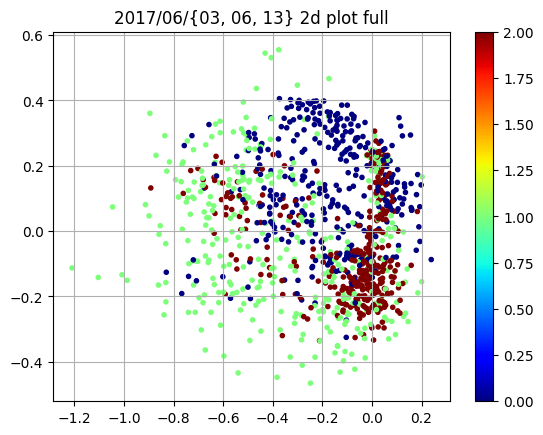

In [114]:
import pylab

plt.figure()
plt.scatter(datX[:, 0], datX[:, 1], marker='.', c=datY, cmap=pylab.cm.jet)
plt.colorbar()
# plt.xlim((-6, 6))
# plt.ylim((-6, 6))
plt.grid()
plt.title("2017/06/{03, 06, 13} 2d plot full")
plt.savefig("./test_2.png")
plt.show()

# t-sne

In [10]:
from sklearn.manifold import TSNE
from sklearn import preprocessing
import plotly
import plotly.offline as offline
import plotly.plotly as py
import plotly.graph_objs as go
# offline.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username="yukiota", api_key="A7epoJ34o1g8MFpHcqYt")

In [11]:
# 3d
tsne = TSNE(n_components=3,
                       init="random",
                       verbose=1
                       )

datX_new = tsne.fit_transform(datX, y=datY)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1104
[t-SNE] Computed conditional probabilities for sample 1104 / 1104
[t-SNE] Mean sigma: 2.522730
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.582051
[t-SNE] Error after 575 iterations: 0.582051


In [15]:
# 2d
tsne_2d = TSNE(n_components=2,
                       init="random",
                       verbose=1
                       )

datX_new_2d = tsne_2d.fit_transform(datX, y=datY)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1104
[t-SNE] Computed conditional probabilities for sample 1104 / 1104
[t-SNE] Mean sigma: 2.522730
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.613201
[t-SNE] Error after 250 iterations: 0.613201


In [16]:
datX_new.shape

(1104, 3)

In [17]:
datY

array([0, 0, 1, ..., 2, 0, 2])

In [19]:
marker_dic = dict(
                        sizemode='diameter',
                        color = datY, # preprocessing.LabelEncoder().fit_transform(datY),
                        colorscale = 'Portland',
                        colorbar=dict(title="colorbar"),
                        line=dict(color='rgb(255, 255, 255)'),
                        opacity=0.9,
                        size=5)

trace3d = go.Scatter3d(x=datX_new[:, 0], 
                     y=datX_new[:, 1], z=datX_new[:, 2],
                     mode='markers',
                    marker=marker_dic)

trace2d = go.Scatter(x=datX_new_2d[:, 0], 
                     y=datX_new_2d[:, 1],
                     mode='markers',
                    marker=marker_dic)

data=[trace3d]
layout=dict(height=700, width=900, title='3d plot')
fig_3d = go.Figure(data=data, layout=layout)


data=[trace2d]
layout=dict(height=700, width=900, title='2d plot')
fig_2d = go.Figure(data=data, layout=layout)

In [20]:
py.iplot(fig_2d, filename="test")

In [21]:
py.iplot(fig_3d, filename="test")

# decode

/Users/yukiota/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:173: UserWarning:

nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.



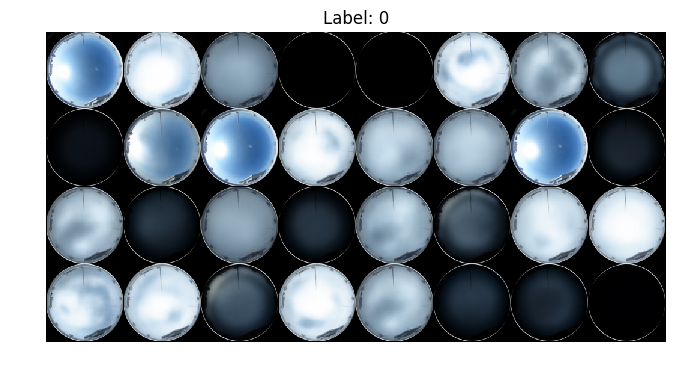

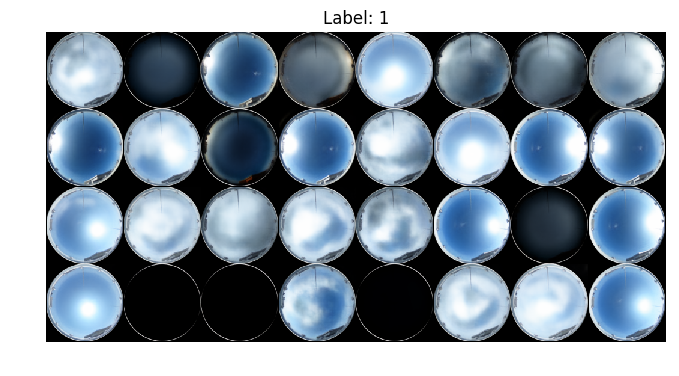

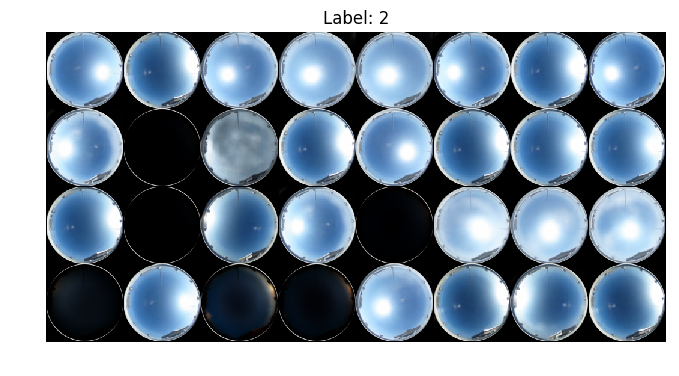

In [22]:
for target_label in range(0, 3):
    target_label = target_label
    dat_target = torch.from_numpy(datX[np.where(datY == target_label)])
    images = model.decode(dat_target[:32])
    
    plt.figure(figsize=(8, 8))
    imshow(make_grid(images, nrow=len(images)//4, padding=1))
    plt.axis('off')
    plt.title("Label: %s" % (target_label))
    plt.show()

In [153]:
tmp = False

In [156]:
a = not tmp and False

In [160]:
import datetime


In [170]:
datetime.datetime.now().strftime('%Y%m%d_%H%M')

'20180724_1729'